In [13]:
import pandas as pd
import numpy as np
from scipy.special import expit

In [321]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [243]:
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [278]:
import weight_of_evidence

In [298]:
import importlib
importlib.reload(weight_of_evidence)

<module 'weight_of_evidence' from '/Users/olivercairns/Desktop/code/WeightOfEvidenceDemo/weight_of_evidence.py'>

In [61]:
np.random.seed=1234

In [204]:
company_age = np.arange(1,100,0.4)

In [205]:
linear_risk = expit((company_age - company_age.mean()) / company_age.std())

In [206]:
linear_outcome = simulate_outcome(linear_risk)

In [456]:
def discrete_fn(company_age):
    if company_age < 5:
        return 0.01
    elif company_age < 95:
        return 0.5
    else:
        return 0.99

In [457]:
def non_mono_fn(company_age):
    if company_age <= 25:
        return 0.25
    elif company_age <= 75:
        return 0.75
    else:
        return 0.25

In [458]:
discrete_vec = np.vectorize(discrete_fn)

In [459]:
non_mono_vec = np.vectorize(non_mono_fn)

In [460]:
discrete_risk = discrete_vec(company_age)

In [461]:
non_mono_risk = non_lin_vec(company_age)

In [462]:
def simulate_outcome(risk_vector):
    random_draws = np.random.uniform(size=risk_vector.shape)
    return (risk_vector > random_draws).astype(int)

In [463]:
SCENARIOS = [(linear_risk, 'linear'),
    (discrete_risk, 'discrete'),
                      (non_mono_risk, 'non-monotonic')]

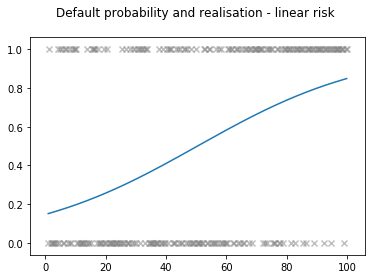

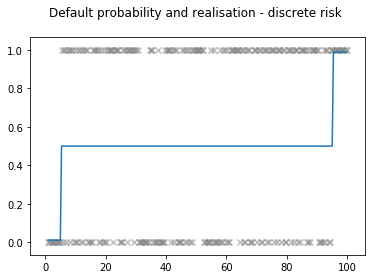

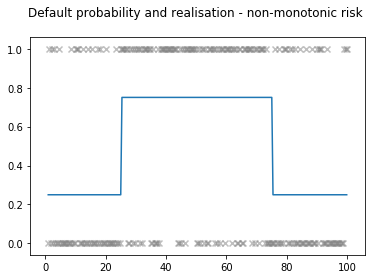

In [464]:
for risk_vector, plot_name in SCENARIOS:
    outcome = simulate_outcome(risk_vector)
    plt.plot(company_age,risk_vector)
    plt.scatter(company_age,outcome,marker='x',color='grey',alpha=0.5)
    plt.title(f'Default probability and realisation - {plot_name} risk \n')
    plt.show()

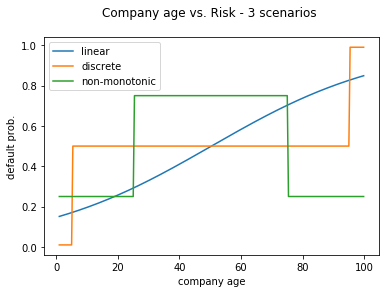

In [467]:
plt.plot(company_age,linear_risk)
plt.plot(company_age,discrete_risk)
plt.plot(company_age,non_mono_risk)
plt.legend(['linear','discrete','non-monotonic'])
plt.title('Company age vs. Risk - 3 scenarios \n')
plt.xlabel('company age')
plt.ylabel('default prob.')

plt.show()

In [468]:
log_reg = LogisticRegression(solver='lbfgs')

In [469]:
MODELS = (('random forest',
  RandomForestClassifier()),
('log reg',LogisticRegression(solver='lbfgs')))

In [470]:
results = {'scenario':[],'auc':[],'model':[]}
for risk_vector, scenario_name in SCENARIOS:
    for model_name, classifier in MODELS: 
        for _ in range(10):
            y_train = simulate_outcome(risk_vector)
            y_test  = simulate_outcome(risk_vector)
            X = np.array([company_age]).T
            classifier.fit(X,y_train)
            y_pred = classifier.predict_proba(X)[:,1]
            auc = roc_auc_score(y_test,y_pred)
            results['scenario'].append(scenario_name)
            results['auc'].append(auc)
            results['model'].append(model_name)
        

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


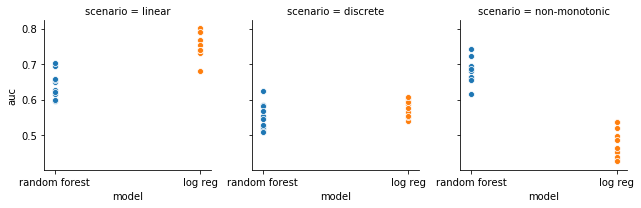

In [471]:
g = sns.FacetGrid(data=pd.DataFrame(results),col='scenario',hue='model')
g.map(sns.scatterplot,'model','auc')

In [472]:
tree_binner = weight_of_evidence.TreeBinner(max_depth=2)

In [473]:
y_train = simulate_outcome(non_mono_risk)
y_test  = simulate_outcome(non_mono_risk)


In [474]:
X = pd.DataFrame(data=X, columns=['company_age'])

In [475]:
y_train = pd.Series(y_train)

In [476]:
X_binned= tree_binner.fit_transform(X,y_train)

In [477]:
X_binned.company_age.unique()

array(['(-inf, 5.4]', '(5.4, 75.0]', '(75.0, inf]'], dtype=object)

In [478]:
woe_scaler = weight_of_evidence.WoeScaler()

In [479]:
X_scaled = woe_scaler.fit_transform(X_binned,y_train)

In [480]:
woe_scaler.woe_values_

{'company_age': {'(-inf, 5.4]': -0.6931471805599454,
  '(5.4, 75.0]': 0.30110509278392145,
  '(75.0, inf]': -0.9734491457141039}}

In [481]:
woebin_logit = Pipeline(
        steps=[
            ("tree_bin", weight_of_evidence.TreeBinner(max_depth=2)),
            ("woe_scale", weight_of_evidence.WoeScaler()),
            ("standard_scale", StandardScaler()),
            ('log_reg_classifier',LogisticRegression(solver='lbfgs') ),
        ]
    )

In [482]:
for risk_vector, scenario_name in SCENARIOS:
    for _ in range(10):
        y_train = pd.Series(simulate_outcome(risk_vector))
        y_test  = simulate_outcome(risk_vector)
        X = np.array([company_age]).T
        X = pd.DataFrame(data=X, columns=['company_age'])
        
        woebin_logit.fit(X,y_train)
        y_pred = woebin_logit.predict_proba(X)[:,1]
        auc = roc_auc_score(y_test,y_pred)
        results['scenario'].append(scenario_name)
        results['auc'].append(auc)
        results['model'].append('woebinned log reg')

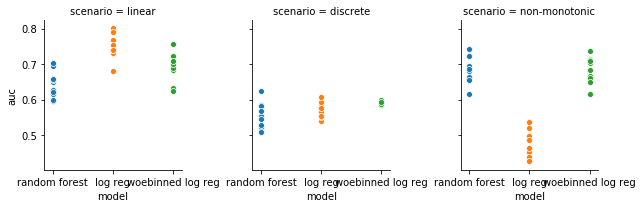

In [485]:
g = sns.FacetGrid(data=pd.DataFrame(results),col='scenario',hue='model')
g.map(sns.scatterplot,'model','auc')

In [489]:
pd.DataFrame(results).groupby(['scenario','model'])[['auc']].mean()

auc
scenario      model                      
discrete      log reg            0.577635
              random forest      0.553739
              woebinned log reg  0.590616
linear        log reg            0.753403
              random forest      0.641875
              woebinned log reg  0.684445
non-monotonic log reg            0.478461
              random forest      0.678089
              woebinned log reg  0.685305